# LangGraph

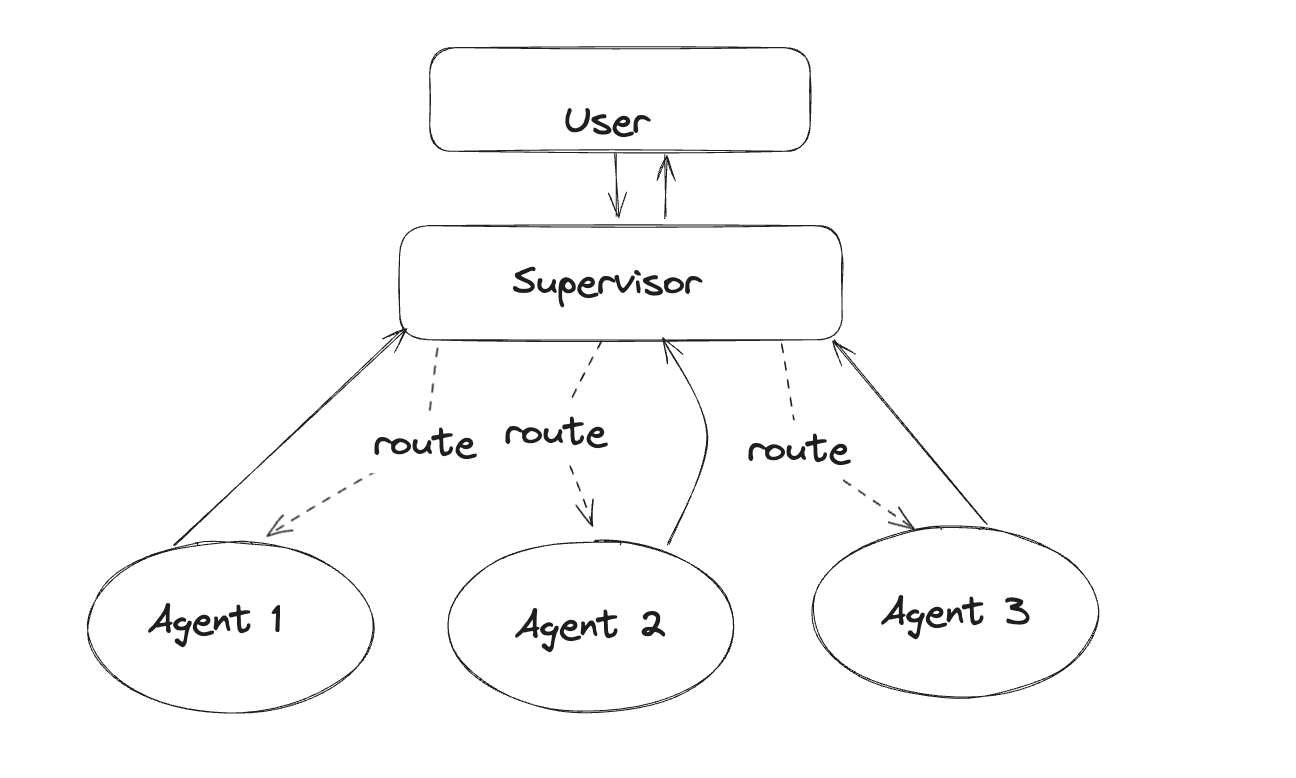

In [1]:
# Import required modules

import json
import operator
import functools
import itertools
from langchain.agents import AgentExecutor, create_openai_tools_agent, create_openai_functions_agent
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain_core.prompts import (ChatPromptTemplate,MessagesPlaceholder,)
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain.pydantic_v1 import BaseModel, Field

import os
from dotenv import load_dotenv

load_dotenv('.env')

True

## Download Chinook db 

In [2]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


### Define LLM Model

In [3]:
# Define LLM Model

from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings

def get_llm(
    azure_deployment="gpt-4",
    api_version="2024-06-01",
    temperature=0,
    timeout=600,
    max_tokens=4096,
    max_retries=1,
):
    return AzureChatOpenAI(
        azure_deployment=azure_deployment,
        api_version=api_version,
        temperature=temperature,
        timeout=timeout,
        max_tokens=max_tokens,
        max_retries=max_retries,
    )

llm = get_llm()

In [4]:
llm.invoke("tell me a joke")

AIMessage(content="Why don't skeletons fight each other?\n\nThey don't have the guts.", response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 11, 'total_tokens': 26}, 'model_name': 'gpt-4', 'system_fingerprint': 'fp_e49e4201a9', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'low'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'low'}}}, id='run-6deb9bde-b86f-47a7-a68b-41c92b32b9cd-0', usage_metadata={'input_tokens': 11, 'output_tokens': 15, 'total_tokens': 26})

### Create Tools for Agents

In [5]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

# Internet search tool
internet_tool = TavilySearchResults(max_results=5)

# Python shell to execute python code
python_repl_tool = PythonREPLTool()

# Print the name and description of the tools
print(python_repl_tool.name, " :: ", python_repl_tool.description)
print(internet_tool.name, " :: ", internet_tool.description)

Python_REPL  ::  A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.
tavily_search_results_json  ::  A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.


#### Agent Prompts

In [6]:
# Define the agent prompts

internet_agent_prompt = """You are an AI agent with access to internet resources and search tool. You can gather context about a question from internet and write a response to the user question.
The internet tool gathers data from trusted online sources from the internet and tries to answer the user question based on relevant context gathered from the internet based on the user question.
The internet tool has access to information about history of beer brands and can answer similar questions. The internet also has information about what is the sentiment of people towards beer brands and can answer similar questions."""

python_agent_prompt = """You are a highly intelligent AI agent who is a master of python, the proogramming language. You can do quick analysis by generating syntactically correct python code and executing the python code using PythonREPL tool and generate extremely valuable insights to answer the user question.
This tool can write and execute python code to do basic data manipulation and analysis, build small machine learning models, etc. and can peroform tasks where python programs can help.
It can also use python libraries to do more complex data analysis like finding correlation, heatmap, simple linear regression and clustering to draw insights.


<question>Forecast the sales for Budweiser in the US/question>
<logic>Use `python_repl` tool since you can write and execute some python code to analyze the data, build a forecasting model and present your final output.</logic>

INSTRUCTIONS to follow while writing pytohn code:
1. Always install required libraries at the beginning of the code using 'pip install package_name'
2. Load the data from the csv file using df = pd.read_csv("input_data.csv")
3. Understand the data by checking the shape, columns, data types, missing values etc.
4. Do the required exploratory data analysis to get the required data for the analysis
5. Write the code to do the analysis and get the final output
6. If you need to train any machine learning model, you can do that as well.

Always output just python code and no additional instructions or notes as a prefix or suffix. Strictly return executable python code only.
"""

sql_agent_prompt = """You are an experienced SQL analyst. Your job is to convert a natural language question to a sql query that can be used to query a database and fetch data.
You have access to the Chinook.db database which contains information about music tracks, albums, artists, playlists, etc. and can answer questions related to the database."""

### Create SQL Agent 

In [7]:
# Create the SQL Tool

from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain.agents.agent_types import AgentType

# Set up the SQL database connection
db = SQLDatabase.from_uri('sqlite:///Chinook.db')

# Set up the SQL database toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# Create the SQL agent
sql_agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    return_intermediate_steps=True
)

# sql_agent_executor.invoke("What are the top 5 tracks by length?")

### SQL Tool

In [8]:
# Create a Tool using SQL Agent

from typing import Optional, Type

from langchain_core.prompts.chat import SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.callbacks.manager import AsyncCallbackManagerForToolRun, CallbackManagerForToolRun
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool

class SQLToolArgs(BaseModel):
    query: str = Field(description="User Query to be answered")

sql_tool_desc = "A tool to query the database and get the required data. Its a NL to SQL engine connected to the Chinook database."

class SQLTool(BaseTool):
    name = "SQLTool"
    description = sql_tool_desc
    args_schema: Type[BaseModel] = SQLToolArgs

    def _run(self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        """Use the tool."""
        response = sql_agent_executor.invoke(query)
        return response

    async def _arun(self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None) -> str:
        """Use the tool asynchronously."""
        return None
    
sql_tool = SQLTool()
out =  sql_tool._run(query="What are the top 5 tracks by length?")



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
Invoking: `sql_db_schema` with `{'table_names': 'Track'}`



CREATE TABLE "Track" (
	"TrackId" INTEGER NOT NULL, 
	"Name" NVARCHAR(200) NOT NULL, 
	"AlbumId" INTEGER, 
	"MediaTypeId" INTEGER NOT NULL, 
	"GenreId" INTEGER, 
	"Composer" NVARCHAR(220), 
	"Milliseconds" INTEGER NOT NULL, 
	"Bytes" INTEGER, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	PRIMARY KEY ("TrackId"), 
	FOREIGN KEY("MediaTypeId") REFERENCES "MediaType" ("MediaTypeId"), 
	FOREIGN KEY("GenreId") REFERENCES "Genre" ("GenreId"), 
	FOREIGN KEY("AlbumId") REFERENCES "Album" ("AlbumId")
)

/*
3 rows from Track table:
TrackId	Name	AlbumId	MediaTypeId	GenreId	Composer	Milliseconds	Bytes	UnitPrice
1	For Those About To Rock (We Salute You)	1	1	1	Angus Young, Malcolm Young, Brian Johnson	343719	11170334	0.99
2	Balls to the Wall	2	2	1	None	3

In [9]:
"""Create Agent using the tools"""

def create_agent(llm, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="history"),
            ("human", "{query}"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )

    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
    return executor

# create internet agent
internet_agent = create_agent(
    llm = llm,
    tools = [internet_tool],
    system_prompt=internet_agent_prompt,
)

# create python agent
python_agent = create_agent(
    llm = llm,
    tools = [python_repl_tool],
    system_prompt=python_agent_prompt,
)

# create sql agent
sql_agent = create_agent(
    llm = llm,
    tools = [sql_tool],
    system_prompt=sql_agent_prompt,
)


In [10]:
members = [
    "Internet",
    "Python",
    "SQL",
]
options = ["FINISH"] + members
tool_desc = [
    tool.description.strip() for tool in [internet_tool, python_repl_tool, sql_tool]
]

tool_desc = "\n\n".join([f"{key}:{value}" for key, value in zip(members, tool_desc)])

print(tool_desc)

Internet:A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.

Python:A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.

SQL:A tool to query the database and get the required data. Its a NL to SQL engine connected to the Chinook database.


### Supervisor prompts

In [11]:
"""Agent Supervisor prompt"""

supervisor_prompt = """
    You are an AI Supervisor tasked with managing a conversation between the\
    following workers:  {members}. Given the following user request,\
    respond with the worker to act next. Each worker will perform a\
    task and respond with their results and status. When finished,\
    respond with FINISH. Always try to understand the true nature of the question and\
    then choose the options accordingly as per specified tool descriptions. Think step by step.\
    The tool descriptions is provided under section `tool_description` where we have specified description for each tool and using which we need to select the appropriate tool.\
    Next We have section `tool_outcome` where we provide the information of what tool was selected prior to current and what was the outcome of the tool, Upon reviewing the outcome of the tool the agent needs to decide whether\
    we should proceed with a new tool or FINISH the execution and this call needs to be made with extreme caution.\
    Do not use the same tool again and again.\
    Avoid using a particular tool if the tool has already been used i.e. if the tool get mentioned under section `tool_outcome`.
    If SQL tool is not able to answer the question, then you can use the internet tool to answer the question since there will be some information available on the internet about perception of people towards our brands.\

"""

In [12]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_prompt),
        (
            "system",
            "tool_description in the form of Tool : description-\n\n{tool_description}",
        ),
        (
            "human",
            "steps in the form of Tool : Outcome-\n\n{tool_outcome}\n if the placeholder is blank that means that this question is asked for the first time.",

        ),
        ("human", "The actual query raised by the human-\n\n {query}"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Take a definitive call and avoid re-selection of the same tool used prior. Select one of the tools-\n\n{options}. Do not select the same tool again."
            "\nand also provide the modified question which is meant to be answered by the above specified tool in free text format\n"
        ),
        (
            "system",
            "Once we reach the end state `FINISH`, The AI Supervisor should ALWAYS return the summarized results of all the tool outcomes so that we are answering the actual question asked by the user",
        ),
    ]
).partial(options=str(options), members=", ".join(members), tool_description=tool_desc)
print(prompt)

input_variables=['query', 'tool_outcome'] partial_variables={'options': "['FINISH', 'Internet', 'Python', 'SQL']", 'members': 'Internet, Python, SQL', 'tool_description': 'Internet:A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.\n\nPython:A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.\n\nSQL:A tool to query the database and get the required data. Its a NL to SQL engine connected to the Chinook database.'} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['members'], template='\n    You are an AI Supervisor tasked with managing a conversation between the    following workers:  {members}. Given the following user request,    respond with the worker to act next. Each worker will perform a    task and respond 

In [13]:
class Next(BaseModel):
    """Which Tool has to be selected by the Supervisor Agent as per the original question"""

    next_tool: str = Field(description="What tool has to be selected")
    next_question: str = Field(
        description="The new question that needs to be asked to the next selected tool"
    )

supervisor = create_structured_output_runnable(Next, llm, prompt)

C:\Users\40100275\AppData\Local\Temp\ipykernel_23628\3160898622.py:9: LangChainDeprecationWarning: LangChain has introduced a method called `with_structured_output` that is available on ChatModels capable of tool calling. You can read more about the method here: <https://python.langchain.com/docs/modules/model_io/chat/structured_output/>.Please follow our extraction use case documentation for more guidelines on how to do information extraction with LLMs. <https://python.langchain.com/docs/use_cases/extraction/>. If you notice other issues, please provide feedback here: <https://github.com/langchain-ai/langchain/discussions/18154>
  supervisor = create_structured_output_runnable(Next, llm, prompt)


In [14]:
def plan_history_creation(sub_question_ls: list, sub_answer_ls: list):
    message_ls = [
        [HumanMessage(l[0]), AIMessage(l[1])]
        for l in list(zip(sub_question_ls, sub_answer_ls))[::-1]
    ]
    message_history = list(itertools.chain(*message_ls))
    return message_history

In [15]:
class GraphAgentPlan(TypedDict):
    input: str
    tool_outcome: Annotated[List[str], operator.add]
    response: str
    next_tool: str
    next_question: str
    intermediate_question: Annotated[List[list[str]], operator.add]
    intermediate_answer: Annotated[List[list[str]], operator.add]

#### Supervisor node

In [16]:
def supervisor_node(state: GraphAgentPlan):
    """supervisor node for routing"""

    query = state["input"]
    tool_outcome = state["tool_outcome"]
    print(f"====>> The input query to supervisor_node :: {query}")
    print(f"====>> The tool_outcome to supervisor_node :: {tool_outcome}")

    intermediate_question = state["intermediate_question"]
    intermediate_answer = state["intermediate_answer"]

    plan_op = supervisor.invoke(
        {
            "query": query,
            "tool_outcome": tool_outcome,
            "intermediate_question": intermediate_question,
            "intermediate_answer": intermediate_answer
        }
    )

    plan_op = json.loads(plan_op.json())
    print(f"====>> The plan_op to supervisor_node :: {plan_op} and {type(plan_op)}")

    if not plan_op["next_tool"] == "FINISH":
        return {
            "next_tool": plan_op["next_tool"],
            "next_question": plan_op["next_question"],
        }

    else:
        return {
            "next_tool": plan_op["next_tool"],
            # "response": tool_outcome,
            "response": plan_op["next_question"],
        }

In [17]:
def agent_node(state: GraphAgentPlan, agent: AgentExecutor, name: str):
    """Agent caller for Node"""

    query = state["next_question"]

    sub_question_ls = state["intermediate_question"]
    sub_answer_ls = state["intermediate_answer"]

    sub_question_ls = [] if not sub_question_ls else sub_question_ls
    sub_answer_ls = [] if not sub_answer_ls else sub_answer_ls

    print(f"====>> The actual question to the agent_node :: {query} and type:: {type(query)}")
    print(f"====>> The list of historical questions:: {sub_question_ls}")
    print(f"====>> The list of historical answers:: {sub_answer_ls}")

    convo_history = plan_history_creation(sub_question_ls, sub_answer_ls)

    print(f"====>> The conversation history to the agent_node:: {convo_history}")

    op = agent.invoke(
        {
            "query": query,
            "history": convo_history,
        }
    )
    print(f"====>> The outcome of the agent node:: {op}")
    op = op["output"]

    return {
        "intermediate_question": [query],
        "intermediate_answer": [op],
        "response": op,
        "tool_outcome": [f"{name}:{op}"],
    }

In [18]:
def tool_selection(state: GraphAgentPlan):
    if "next_tool" in state and state["next_tool"]:
        print(f"The tool choosen :: {state['next_tool']}")
        return state["next_tool"]
    else:
        None

In [19]:

sql_node = functools.partial(agent_node, agent=sql_agent, name="SQL")
internet_node = functools.partial(agent_node, agent=internet_agent, name="Internet")
python_node = functools.partial(agent_node, agent=python_agent, name="Python")


### Define Graph paths

In [20]:
workflow = StateGraph(GraphAgentPlan)

workflow.add_node("SQL", sql_node)
workflow.add_node("Internet", internet_node)
workflow.add_node("Python", python_node)

workflow.add_node("supervisor", supervisor_node)

for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")

# The supervisor populates the "next" field in the graph statewhich routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

workflow.add_conditional_edges("supervisor", tool_selection, conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

router_agent_app = workflow.compile()

### Graph with supervisor and nodes

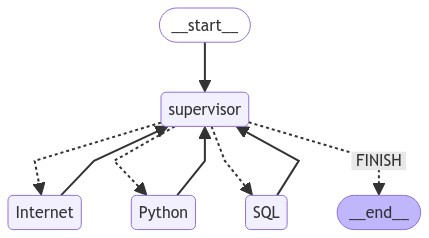

In [21]:
from IPython.display import Image, display

try:
    display(Image(router_agent_app.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [22]:
from langchain_community.callbacks import get_openai_callback

def run_agent(input):
    with get_openai_callback() as cb:
        out = router_agent_app.invoke(input)
        print(cb)
    return out
    
# out = run_agent(inputs)

### Run the Agentic setup

In [23]:
run_agent({"input": "What is the population of the world?"})

====>> The input query to supervisor_node :: What is the population of the world?
====>> The tool_outcome to supervisor_node :: []
====>> The plan_op to supervisor_node :: {'next_tool': 'Internet', 'next_question': 'What is the current population of the world?'} and <class 'dict'>
The tool choosen :: Internet
====>> The actual question to the agent_node :: What is the current population of the world? and type:: <class 'str'>
====>> The list of historical questions:: []
====>> The list of historical answers:: []
====>> The conversation history to the agent_node:: []


> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'current world population'}`


[{'url': 'https://www.worldometers.info/world-population/', 'content': 'Assuming that we start counting from about 50,000 B.C., the time when modern Homo sapiens appeared on the earth (and not from 700,000 B.C. when the ancestors of Homo sapiens appeared, or several million years ago when hominids we

{'input': 'What is the population of the world?',
 'tool_outcome': ['Internet:As of November 15, 2022, the world population has reached 8 billion people according to the United Nations. This marks a significant milestone in human history, reflecting a tremendous change since the industrial revolution. For context, it took all of human history until around 1800 for the world population to reach one billion. The growth rate has accelerated since then, with the second billion achieved in 130 years (1930), the third billion in 30 years (1960), the fourth billion in 15 years (1974), and the fifth billion in only 13 years (1987).'],
 'response': 'The world population has reached 8 billion people as of November 15, 2022, according to the United Nations.',
 'next_tool': 'FINISH',
 'next_question': 'What is the current population of the world?',
 'intermediate_question': ['What is the current population of the world?'],
 'intermediate_answer': ['As of November 15, 2022, the world population has

In [24]:
run_agent({"input": "Take 2 randomly generated lists with 50 values each and find the correlation between them."})

====>> The input query to supervisor_node :: Take 2 randomly generated lists with 50 values each and find the correlation between them.
====>> The tool_outcome to supervisor_node :: []
====>> The plan_op to supervisor_node :: {'next_tool': 'Python', 'next_question': 'import numpy as np\nlist1 = np.random.rand(50)\nlist2 = np.random.rand(50)\ncorrelation = np.corrcoef(list1, list2)[0, 1]\nprint(correlation)'} and <class 'dict'>
The tool choosen :: Python
====>> The actual question to the agent_node :: import numpy as np
list1 = np.random.rand(50)
list2 = np.random.rand(50)
correlation = np.corrcoef(list1, list2)[0, 1]
print(correlation) and type:: <class 'str'>
====>> The list of historical questions:: []
====>> The list of historical answers:: []
====>> The conversation history to the agent_node:: []


> Entering new AgentExecutor chain...


Python REPL can execute arbitrary code. Use with caution.



Invoking: `Python_REPL` with `{'query': 'import numpy as np\nlist1 = np.random.rand(50)\nlist2 = np.random.rand(50)\ncorrelation = np.corrcoef(list1, list2)[0, 1]\nprint(correlation)'}`


0.15673913332411943
```python
import numpy as np
list1 = np.random.rand(50)
list2 = np.random.rand(50)
correlation = np.corrcoef(list1, list2)[0, 1]
print(correlation)
```

> Finished chain.
====>> The outcome of the agent node:: {'query': 'import numpy as np\nlist1 = np.random.rand(50)\nlist2 = np.random.rand(50)\ncorrelation = np.corrcoef(list1, list2)[0, 1]\nprint(correlation)', 'history': [], 'output': '```python\nimport numpy as np\nlist1 = np.random.rand(50)\nlist2 = np.random.rand(50)\ncorrelation = np.corrcoef(list1, list2)[0, 1]\nprint(correlation)\n```'}
====>> The input query to supervisor_node :: Take 2 randomly generated lists with 50 values each and find the correlation between them.
====>> The tool_outcome to supervisor_node :: ['Python:```python\nimport numpy as np\nlist1 = np.random.

{'input': 'Take 2 randomly generated lists with 50 values each and find the correlation between them.',
 'tool_outcome': ['Python:```python\nimport numpy as np\nlist1 = np.random.rand(50)\nlist2 = np.random.rand(50)\ncorrelation = np.corrcoef(list1, list2)[0, 1]\nprint(correlation)\n```'],
 'response': 'The correlation between two randomly generated lists with 50 values each has been calculated.',
 'next_tool': 'FINISH',
 'next_question': 'import numpy as np\nlist1 = np.random.rand(50)\nlist2 = np.random.rand(50)\ncorrelation = np.corrcoef(list1, list2)[0, 1]\nprint(correlation)',
 'intermediate_question': ['import numpy as np\nlist1 = np.random.rand(50)\nlist2 = np.random.rand(50)\ncorrelation = np.corrcoef(list1, list2)[0, 1]\nprint(correlation)'],
 'intermediate_answer': ['```python\nimport numpy as np\nlist1 = np.random.rand(50)\nlist2 = np.random.rand(50)\ncorrelation = np.corrcoef(list1, list2)[0, 1]\nprint(correlation)\n```']}

In [25]:
run_agent({"input": "What are the top 5 tracks by length?"})

====>> The input query to supervisor_node :: What are the top 5 tracks by length?
====>> The tool_outcome to supervisor_node :: []
====>> The plan_op to supervisor_node :: {'next_tool': 'SQL', 'next_question': 'What are the top 5 tracks by length?'} and <class 'dict'>
The tool choosen :: SQL
====>> The actual question to the agent_node :: What are the top 5 tracks by length? and type:: <class 'str'>
====>> The list of historical questions:: []
====>> The list of historical answers:: []
====>> The conversation history to the agent_node:: []


> Entering new AgentExecutor chain...

Invoking: `SQLTool` with `{'query': 'SELECT Name, Milliseconds FROM tracks ORDER BY Milliseconds DESC LIMIT 5'}`




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
Invoking: `sql_db_schema` with `{'table_names': 'Track'}`



CREATE TABLE "Track" (
	"TrackId" INTEGER 

{'input': 'What are the top 5 tracks by length?',
 'tool_outcome': ['SQL:The top 5 longest tracks in the database, ordered by duration (in milliseconds), are:\n\n1. "Occupation / Precipice" - 5,286,953 milliseconds\n2. "Through a Looking Glass" - 5,088,838 milliseconds\n3. "Greetings from Earth, Pt. 1" - 2,960,293 milliseconds\n4. "The Man With Nine Lives" - 2,956,998 milliseconds\n5. "Battlestar Galactica, Pt. 2" - 2,956,081 milliseconds'],
 'response': 'The top 5 longest tracks in the database, ordered by duration (in milliseconds), are:\n\n1. "Occupation / Precipice" - 5,286,953 milliseconds\n2. "Through a Looking Glass" - 5,088,838 milliseconds\n3. "Greetings from Earth, Pt. 1" - 2,960,293 milliseconds\n4. "The Man With Nine Lives" - 2,956,998 milliseconds\n5. "Battlestar Galactica, Pt. 2" - 2,956,081 milliseconds',
 'next_tool': 'FINISH',
 'next_question': 'What are the top 5 tracks by length?',
 'intermediate_question': ['What are the top 5 tracks by length?'],
 'intermediate_ans

In [26]:
run_agent({"input": "What are the top countries with highest number of customers and what is the maximum temperature in 2023 in these countries?"})

====>> The input query to supervisor_node :: What are the top countries with highest number of customers and what is the maximum temperature in 2023 in these countries?
====>> The tool_outcome to supervisor_node :: []
====>> The plan_op to supervisor_node :: {'next_tool': 'SQL', 'next_question': 'What are the top countries with the highest number of customers?'} and <class 'dict'>
The tool choosen :: SQL
====>> The actual question to the agent_node :: What are the top countries with the highest number of customers? and type:: <class 'str'>
====>> The list of historical questions:: []
====>> The list of historical answers:: []
====>> The conversation history to the agent_node:: []


> Entering new AgentExecutor chain...

Invoking: `SQLTool` with `{'query': 'SELECT Country, COUNT(CustomerId) AS NumberOfCustomers FROM Customers GROUP BY Country ORDER BY NumberOfCustomers DESC'}`




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


Album, Artist, Custo

{'input': 'What are the top countries with highest number of customers and what is the maximum temperature in 2023 in these countries?',
 'tool_outcome': ['SQL:The top countries with the highest number of customers in the Chinook database are:\n\n1. USA - 13 customers\n2. Canada - 8 customers\n3. France - 5 customers\n4. Brazil - 5 customers\n5. Germany - 4 customers\n6. United Kingdom - 3 customers\n7. Portugal - 2 customers\n8. India - 2 customers\n9. Czech Republic - 2 customers\n\nThese are the top 9 countries by customer count. Other countries have 1 customer each.',
  "Internet:Here are the maximum temperatures recorded in 2023 for the specified countries:\n\n1. **USA**: The specific maximum temperature for 2023 wasn't directly mentioned, but the year was noted for its record heat, impacting approximately 65 million people. [Source](https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202313)\n\n2. **Canada**: Lytton, B.C. recorded the highest temperature in Canada